# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import os
import time
import numpy as np
from glob import glob
import cv2                
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import models
import torchvision.models as models
from torchvision import datasets

import torchvision.transforms as T
#import torchvision.transforms as transforms

import torch.optim.lr_scheduler as scheduler
import torch.optim as optim

from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import matplotlib.pyplot as plt                        
%matplotlib inline                               

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


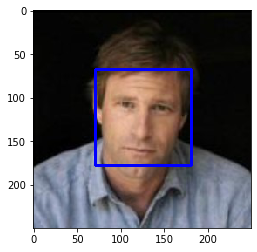

In [2]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

##### HAAR Cascade model
* 96.0% of the time, there are humans detected in the humans dataset.
* 18.0% of the time, there are humans detected in the dogs dataset.

##### Keypoint model trained with Coco dataset:
* 100.0% of the time, there are humans detected in the humans dataset.
* 11.0% of the time, there are humans detected in the dogs dataset.

##### Additionally, I created two types of lists based on:
* the human data set, I tracked the images which a face was **not** detected
* the dog data set, I tracked the images which a face **was** detected

##### I created two ImageGrids based on these lists to easily visualize if there are errors where:
* the faces were **not** detected in the human data set
* the faces **were** detected in the dog data set

##### Based on these two lists, I decided to find if there were any images in both. Of the two models:
* there are no images that intersect where they were misclassified using the human data set.
* there were 8 images that intersect where they could be misclassified using the dog data set.


Inspecting further on the images misclassified by the HAAR Cascase model, it would look like it was created using images from an American or European descent so a more diverse data set may yield better accuracy. This is of course a sensitive point in AI these days with various companies suspending facial recognition. Regardless, it's all a learning experience for me so I enjoyed it.

The keypoint model did not seem to have the same problem. While it wasn't able to detect faces in all images initially (1), I think that was a result of not being able to find the white part of the eyes as an example. Looking at two problematic images below, I believe this is likely why since the keypoint model uses a cnn and probably trained on specific features of the face. I didn't check the scores on these two so it's possible the threshold was just a bit higher that the score. _Since this was an optional section, I'll go back and revisit later._ 

(1) As I mentioned initially the keypoint model wasn't able to detect all the faces, but by resizing the images, I achieved 100% of humans in the human data set. Additionally, by center cropping the images in the dog data set, I went from 22% to 11% in detecting humans. That is likely because humans tend to be on the side of their furry friend of which the dog is typically in the center of the picture. Regardless of 11%, about 2% of the 11% of those images did actually contain humans.

As I mentioned earlier here, I did some visual inspection to analyze the results from the two models. 

I also tried various other methods to detect faces which I did not include in my writeup.

##### Some were successful (but not included here):
* Selective search
* grabcut
* darknet
* torchvision.models.detection.maskrcnn_resnet50_fpn

##### Some were not:
* Canny edge detection/Hough transform

I decided to go with keypointrcnn_resnet50_fpn in pyTorch in the end since it had facial keypoints. I probably spent way too much time on this, but learned a lot. There are some additional comments in the following cells in this section.

In [4]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#
from mpl_toolkits.axes_grid1 import ImageGrid

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
def detect_faces(image_set, humans_dataset=True):
    human_count = 0
    detected_list = list([])
    image_set_size = len(image_set)
    for index in range(image_set_size):
        if face_detector(image_set[index]) == True:
            human_count += 1
            if humans_dataset == False:
                detected_list.append(index)
        else:
            if humans_dataset:           
                detected_list.append(index)
    return float((human_count / image_set_size) * 100), detected_list

In [5]:
humans_humans_percentage, humans_humans_list = detect_faces(human_files_short, True)
print(str(humans_humans_percentage) + "% of the time, there are humans in humans dataset.")

humans_dogs_percentage, humans_dogs_list = detect_faces(dog_files_short, False)
print(str(humans_dogs_percentage) + "% of the time, there are humans in dogs dataset.")

96.0% of the time, there are humans in humans dataset.
18.0% of the time, there are humans in dogs dataset.


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [6]:
### (Optional) 
### COMPLETED: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

# define KEYPOINTRCNN_RESTNET50 model
KEYPOINTRCNN_RESTNET50 = models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
KEYPOINTRCNN_RESTNET50.eval()
# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    KEYPOINTRCNN_RESTNET50 = KEYPOINTRCNN_RESTNET50.cuda()

In [7]:
print(KEYPOINTRCNN_RESTNET50)

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
     

In [8]:


THRESHOLD = 0.95
FACIAL_KEYPOINTS = 5
COCO_PERSON_KEYPOINT_NAMES = ['nose', 'left eye', 'right eye', 'left ear', 'right ear', 'left shoulder', 'right shoulder', 
                              'left elbow', 'right elbow', 'left wrist', 'right wrist', 'left hip', 'right hip', 
                              'left knee', 'right knee', 'left ankle', 'right ankle']



def KEYPOINTRCNN_RESTNET50_predict(img, humans_dataset):
    # open image
    img = Image.open(img).convert('RGB')

    # depending on data set, use different transform
    if humans_dataset:
        transform = T.Compose([T.Resize(256), T.ToTensor()])        
    else:
        transform = T.Compose([T.CenterCrop(224), T.ToTensor()])

    # push img through transform
    input_tensor = transform(img)

    # create a mini-batch
    batch = input_tensor.unsqueeze(0)
    
    # move the batch to GPU; model already moved to GPU
    if use_cuda:
        batch = batch.cuda()

    with torch.no_grad():
        predictions = KEYPOINTRCNN_RESTNET50(batch)

    return predictions[0]
    
def face_detector_keypoint(img, humans_dataset):
    facial_features = False
    predictions = KEYPOINTRCNN_RESTNET50_predict(img, humans_dataset)
    scores = predictions['scores'].cpu().detach().numpy() 
    keypoints = predictions['keypoints'].to(torch.int16).cpu().numpy()[:, :2]

    for score in scores:
        if score < THRESHOLD:
            continue

        for idx, k in enumerate(keypoints[0:FACIAL_KEYPOINTS]):
            facial_features = True

    return facial_features

def detect_faces_keypoint(image_set, humans_dataset=True):
    human_count = 0
    detected_list = list([])
    image_set_size = len(image_set)
    for index in range(image_set_size):
        if face_detector_keypoint(image_set[index], humans_dataset) == True:
            human_count += 1
            if humans_dataset == False:
                detected_list.append(index)
        else:
            if humans_dataset:           
                detected_list.append(index)
    return float((human_count / image_set_size) * 100), detected_list

In [9]:
humans_humans_percentage_keypoint, humans_humans_list_keypoint = detect_faces_keypoint(human_files_short, True)
print(str(humans_humans_percentage_keypoint) + "% of the time, there are humans in humans dataset.")

humans_dogs_percentage_keypoint, humans_dogs_list_keypoint = detect_faces_keypoint(dog_files_short, False)
print(str(humans_dogs_percentage_keypoint) + "% of the time, there are humans in dogs dataset.")

C:\Users\miker\Anaconda3\envs\deep-learning\lib\site-packages\torch\nn\functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


100.0% of the time, there are humans in humans dataset.
11.0% of the time, there are humans in dogs dataset.


In [10]:
PADDING = 0.3
COLS = 6
FIGURE_SIZE_DIMENSION_FACTOR = 6.

def show_images(image_subset, image_set):
    image_list_len = len(image_subset)
                     
    # validate list of images to show
    if image_list_len == 0:
        print("Image List is empty!")
        return
    
    # caclculate # of rows & cols to present images
    rows = image_list_len // COLS
    if image_list_len % COLS != 0:
        rows += 1
    
    fig_size_val = (FIGURE_SIZE_DIMENSION_FACTOR*rows, FIGURE_SIZE_DIMENSION_FACTOR*COLS)
    fig = plt.figure(figsize=fig_size_val)
    grid = ImageGrid(fig, 111, nrows_ncols=(rows, COLS), axes_pad=PADDING, cbar_set_cax=False)

    for idx, (ax, im) in enumerate(zip(grid, image_subset)):
        img = cv2.imread(image_set[image_subset[idx]])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (50,50), interpolation = cv2.INTER_AREA)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Index: {}'.format(image_subset[idx]))
        ax.imshow(img)

    plt.show()

HAAR Cascades Image Grid of misclassified humans


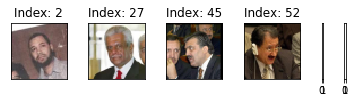

HAAR Cascades Image Grid of misclassified dogs as humans


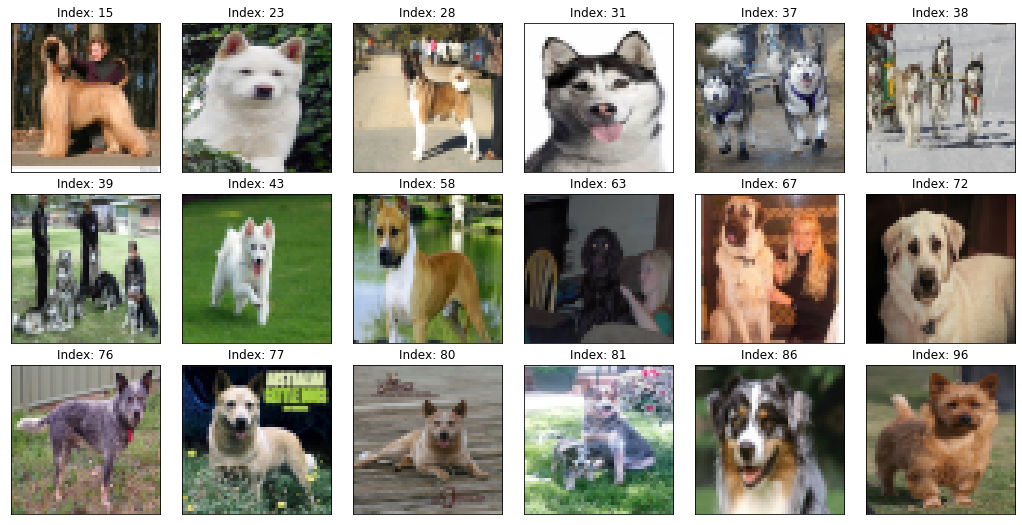

In [11]:
# HAAR Cascades
print("HAAR Cascades Image Grid of misclassified humans")
show_images(humans_humans_list, human_files_short)
print("HAAR Cascades Image Grid of misclassified dogs as humans")
show_images(humans_dogs_list, dog_files_short)

keypointrcnn_resnet50_fpn Image Grid of misclassified humans
Image List is empty!
keypointrcnn_resnet50_fpn Image Grid of misclassified dogs as humans


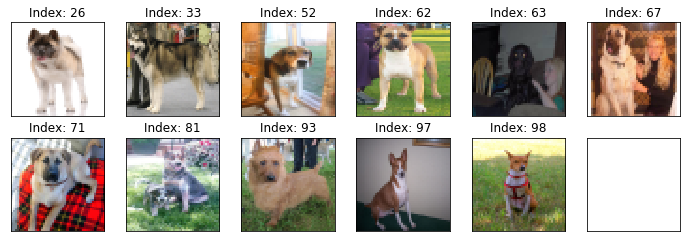

In [12]:
# keypointrcnn_resnet50_fpn
print("keypointrcnn_resnet50_fpn Image Grid of misclassified humans")
show_images(humans_humans_list_keypoint, human_files_short)
print("keypointrcnn_resnet50_fpn Image Grid of misclassified dogs as humans")
show_images(humans_dogs_list_keypoint, dog_files_short)

In [13]:
'''
Investigate if the different face detector algorithms have the same problem recognizing the same image
'''
def get_intersection_of_lists(list_a, list_b):
    return list(set(list_a).intersection(list_b))

def compare_lists(list_a, list_b):
    intersection_list = get_intersection_of_lists(list_a, list_b)
    if len(intersection_list) > 0:
        print(intersection_list)
    else:
        print("There aren't any images that are in both lists!")

In [14]:
print("Results with respect to the same image(s) misclassified by both models")
print("----------------------------------------------------------------------\n")
print("human data set:")
compare_lists(humans_humans_list, humans_humans_list_keypoint)

print("\ndog data set:")
compare_lists(humans_dogs_list, humans_dogs_list_keypoint)

Results with respect to the same image(s) misclassified by both models
----------------------------------------------------------------------

human data set:
There aren't any images that are in both lists!

dog data set:
[81, 67, 63]


In [15]:
HAAR_CASCADE_FRONTAL_FACE_FILE = 'haarcascades/haarcascade_frontalface_alt.xml'

''' 
  Display single image with ractangle around face(s)
'''
def show_face(image):
    # extract pre-trained face detector
    face_cascade = cv2.CascadeClassifier(HAAR_CASCADE_FRONTAL_FACE_FILE)

    # load color (BGR) image
    img = cv2.imread(image)
    # convert BGR image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # find faces in image
    faces = face_cascade.detectMultiScale(gray)

    # get bounding box for each detected face
    for (x,y,w,h) in faces:
        # add bounding box to color image
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.title("Faces detected: {}".format(len(faces)))
    plt.imshow(cv_rgb)
    plt.show()

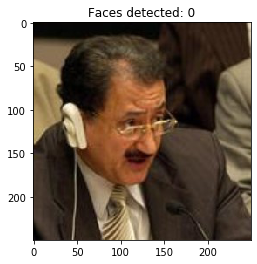

In [16]:
# Show one of the images where a face wasn't detected by the HAAR Cascade
show_face(human_files_short[52])

In [17]:
def show_face_keypoint(img, humans_dataset):
    predictions = KEYPOINTRCNN_RESTNET50_predict(img, humans_dataset)
    detected_faces = 0
    
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(16, 16))
    fig, ax = plt.subplots(1, figsize=(16, 16))

    for box, label, score, keypoints, keypoint_scores in zip(predictions['boxes'], predictions['labels'],
                                                             predictions['scores'], predictions['keypoints'],
                                                             predictions['keypoints_scores']):
        # move data back to CPU
        box = box.to(torch.int16).cpu().numpy()
        label = label.cpu().detach().numpy()
        score = score.cpu().detach().numpy()
        keypoints = keypoints.to(torch.int16).cpu().numpy()[:, :2]
        keypoint_scores = keypoint_scores.cpu().detach().numpy()

        # if doesn't meet threshold, ignore
        if score < THRESHOLD:
            continue

        cv2.rectangle(img, (box[0], box[1]), (box[2],box[3]),color=(0, 0, 255), thickness=1)
        #cv2.putText(img,str('%.2f' % score), (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX, 3, (255,128,255),thickness=3)
        detected_faces += 1
        
        print("Face {}".format(detected_faces))
        for idx, k in enumerate(keypoints[0:FACIAL_KEYPOINTS]):
            print("found {}".format(COCO_PERSON_KEYPOINT_NAMES[idx]))
            #cv2.putText(img,COCO_PERSON_KEYPOINT_NAMES[idx], (k[0]-50, k[1]-25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,128,255),thickness=2)
            cv2.circle(img, (k[0], k[1]), radius=5, color=(0, 255, 0), thickness=-1)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Faces detected: {}".format(detected_faces))
    ax.imshow(img)

Face 1
found nose
found left eye
found right eye
found left ear
found right ear
Face 2
found nose
found left eye
found right eye
found left ear
found right ear


<Figure size 1152x1152 with 0 Axes>

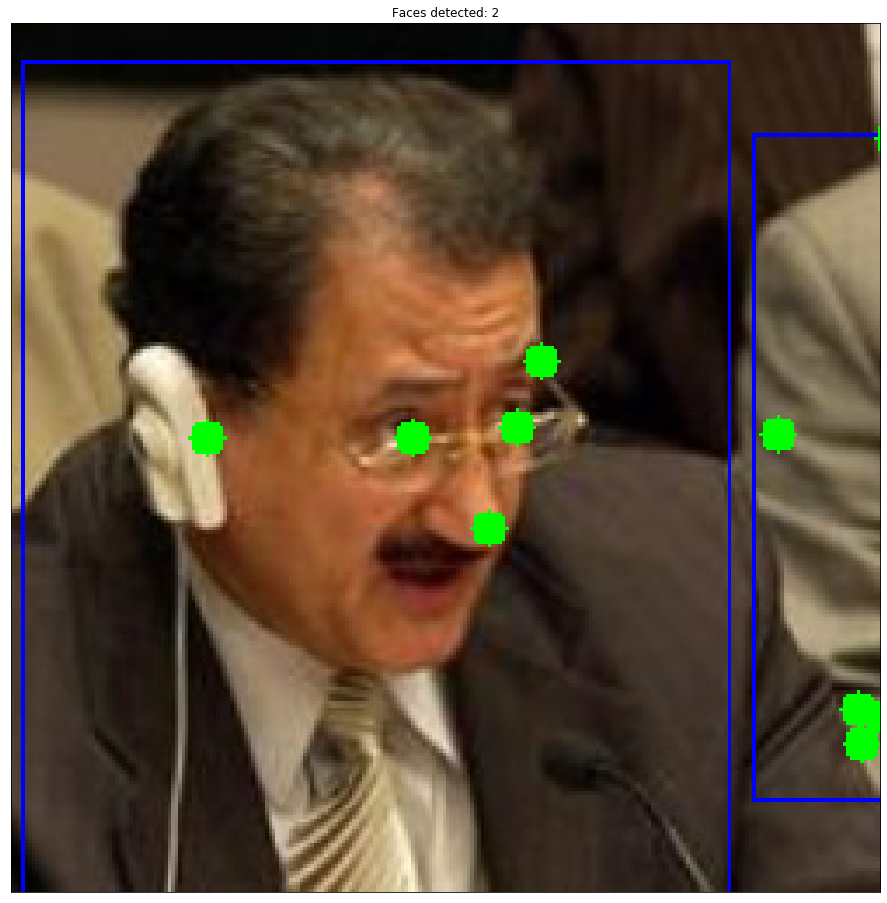

In [18]:
# Show one of the images where a face wasn't detected by the HAAR Cascade, but was by the keypoint model
show_face_keypoint(human_files_short[52], True)

# Note: there's a bug I couldn't figure out where even though I only want to count faces via keypoints
# (COCO_PERSON_KEYPOINT_NAMES < 5 ), it seems to incorrectly detect those keypoints shown below. While there are 
# correctly two people, there is only one face.

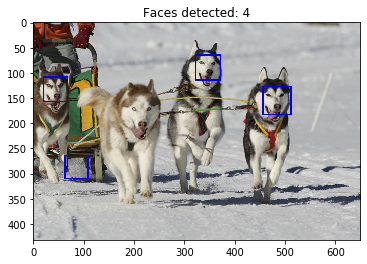

In [19]:
# Ok, let's look at some dog pics and see what we find...

# Sees 3 dog faces as humans and one other square which I'm not sure how that got classified.
show_face(dog_files_short[38])

<Figure size 1152x1152 with 0 Axes>

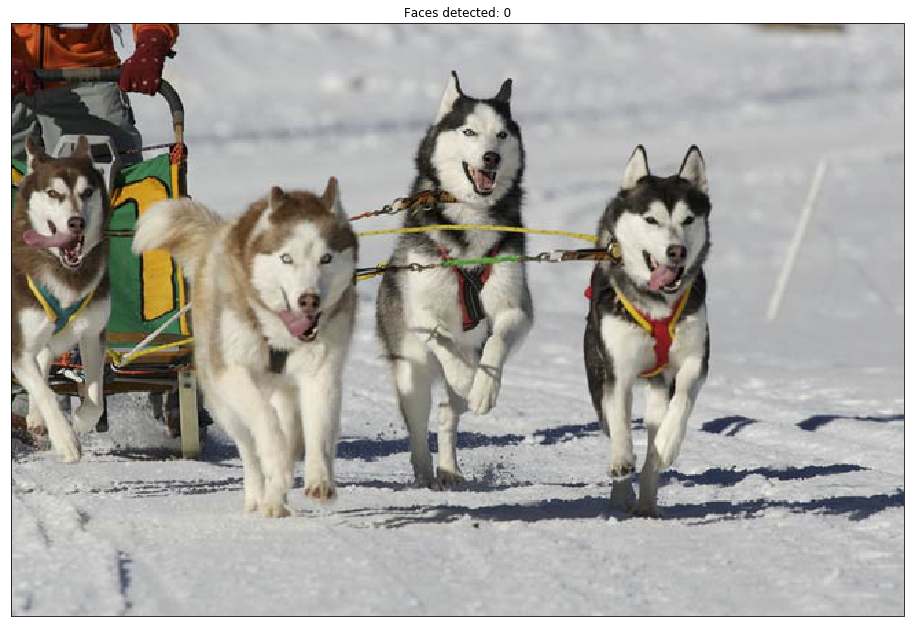

In [20]:
# Better in terms of know where the person is, but no face and somehow finds a nose, eyes and ears...
show_face_keypoint(dog_files_short[38], False)

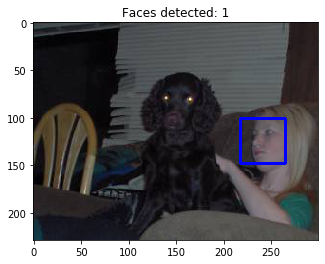

In [21]:
# Sees the human face correctly.
show_face(dog_files_short[63])

Face 1
found nose
found left eye
found right eye
found left ear
found right ear


<Figure size 1152x1152 with 0 Axes>

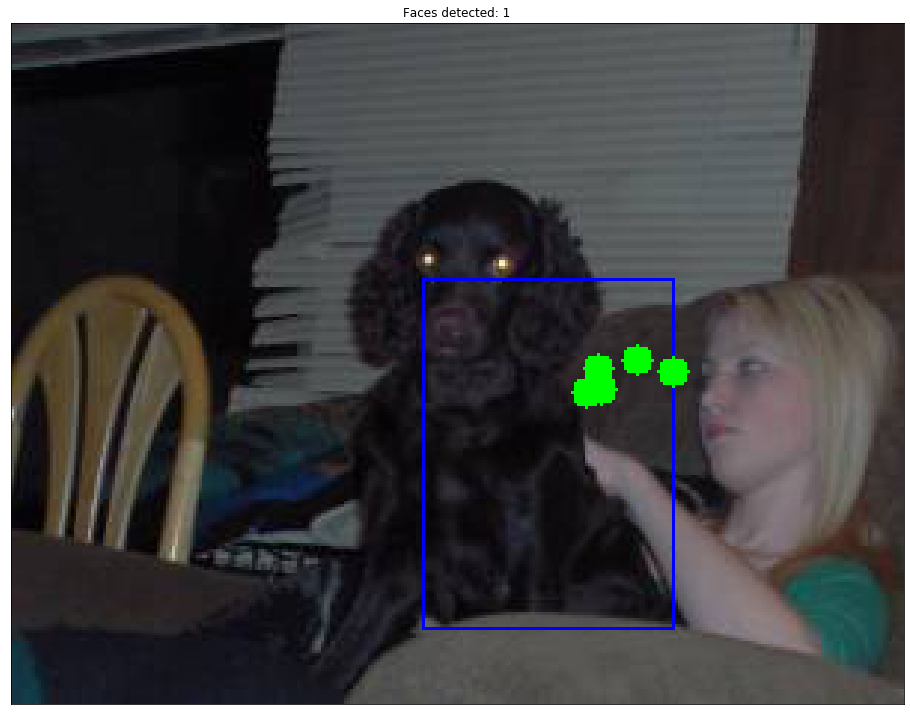

In [22]:
# Also sees the human face correctly. I wasn't why the skew in keypoints except that it may be the tensor
# img key points on the opencv img.
show_face_keypoint(dog_files_short[63], False)

Face 1
found nose
found left eye
found right eye
found left ear
found right ear


<Figure size 1152x1152 with 0 Axes>

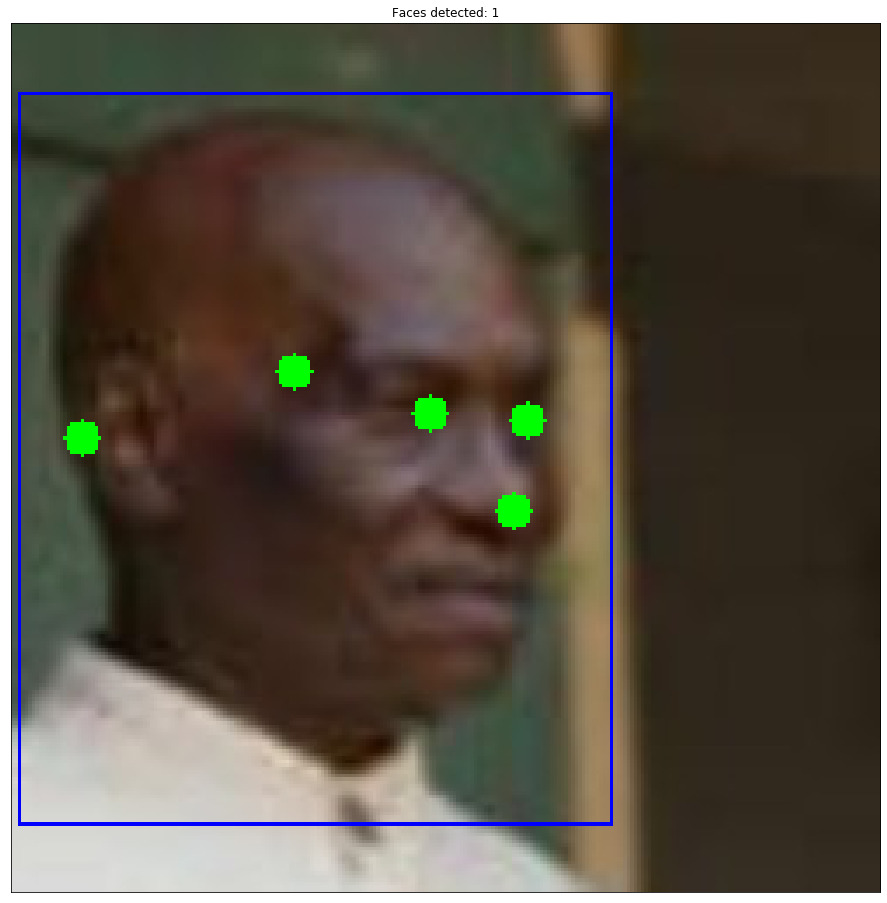

In [23]:
# The keypoint model couldn't detect a face here...
show_face_keypoint(human_files_short[19], True)

Face 1
found nose
found left eye
found right eye
found left ear
found right ear


<Figure size 1152x1152 with 0 Axes>

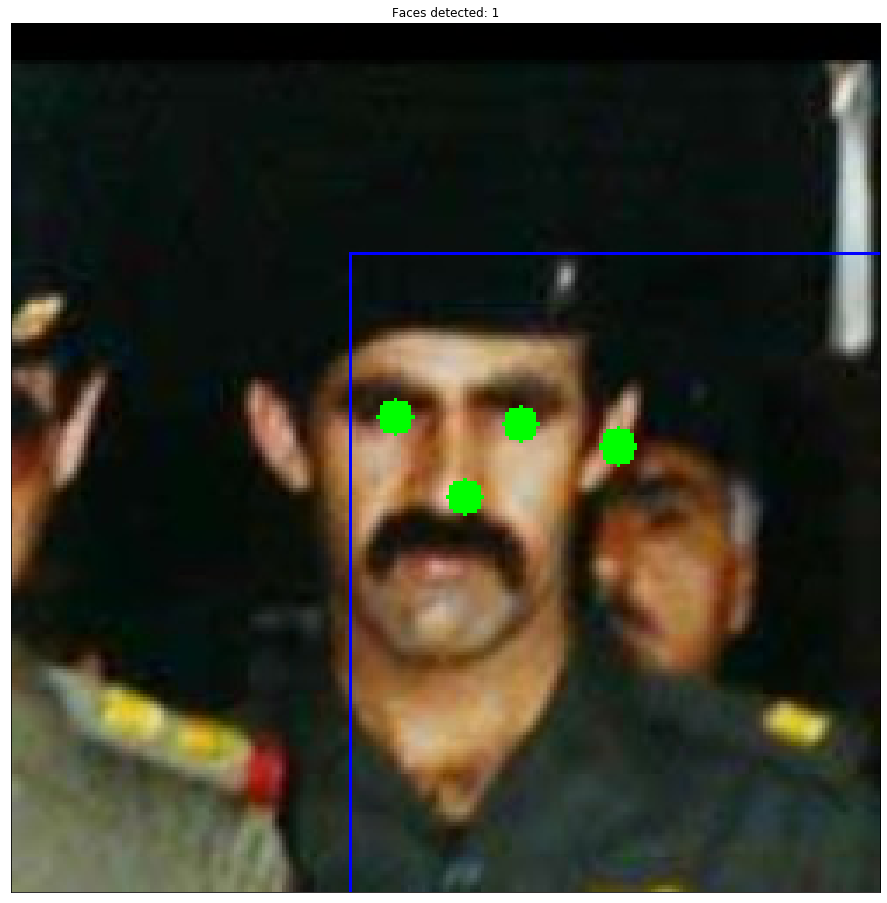

In [24]:
# The keypoint model couldn't detect a face here either...
show_face_keypoint(human_files_short[61], True)

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [25]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

In [26]:
print(VGG16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [27]:
# Set PIL to be tolerant of image files that are truncated.

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    img = Image.open(img_path).convert('RGB')

    normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])    

    # compose transform to preprocess image
    transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor(), normalize])
    input_tensor = transform(img)

    # create a mini-batch
    batch = input_tensor.unsqueeze(0)

    # move the batch to GPU; model already moved to GPU
    if use_cuda:
        batch = batch.cuda()
        
    with torch.no_grad():
        predictions = VGG16(batch)

    # normalize the scores by running softmax to get probablilities
    percentage = torch.nn.functional.softmax(predictions, dim=1)[0] * 100

    # get the max probability
    _, index = torch.max(predictions, 1)
    
    # highest predicted class index
    return index.cpu().numpy()[0] 

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [28]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## COMPLETED: Complete the function.
    prediction = VGG16_predict(img_path)
    return prediction > 150 and prediction < 269 # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

##### VGG16 model trained with Coco dataset:
0.0% of the time, there are dogs in humans dataset.
94.0% of the time, there are dogs in dogs dataset.

##### Resnet50 model trained with Coco dataset:
0.0% of the time, there are dogs in humans dataset.
95.0% of the time, there are dogs in dogs dataset.

##### Inception V3 model trained with Coco dataset:
0.0% of the time, there are dogs in humans dataset.
96.0% of the time, there are dogs in dogs dataset.

I didn't do as much analysis on the dog results since they were near 100%. Certainly the pretrained models have the expectation to predict with high accuracy given the research into the models and dataset as well as tuning the hyperparameters and such. From what I read, it's very common to use pretrained models in real-world scenarios (transfer learning) vs creating a new one from scratch.

In [29]:
### COMPLETED: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
def detect_dogs(image_set, dogs_dataset=True):
    dog_count = 0
    detected_list = list([])
    image_set_size = len(image_set)
    for index in range(image_set_size):
        if dog_detector(image_set[index]) == True:
            dog_count += 1
            if dogs_dataset == False:
                detected_list.append(index)
        else:
            if dogs_dataset:           
                detected_list.append(index)
    return float((dog_count / image_set_size) * 100), detected_list

In [30]:
dogs_humans_percentage, dogs_humans_list = detect_dogs(human_files_short, False)
print(str(dogs_humans_percentage) + "% of the time, there are dogs in humans dataset.")

dogs_dogs_percentage, dogs_dogs_list = detect_dogs(dog_files_short, True)
print(str(dogs_dogs_percentage) + "% of the time, there are dogs in dogs dataset.")

0.0% of the time, there are dogs in humans dataset.
95.0% of the time, there are dogs in dogs dataset.


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [31]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.
# define RESNET50 model
RESNET50 = models.resnet50(pretrained=True)
RESNET50.eval()
# move model to GPU if CUDA is available
if use_cuda:
    RESNET50 = RESNET50.cuda()
    
print(RESNET50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [32]:
def RESNET50_predict(img_path):
    '''
    Use pre-trained RESNET-50 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to RESNET-50 model's prediction
    '''
    ## COMPLETED: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    img = Image.open(img_path).convert('RGB')

    normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])    

    # compose transform to preprocess image
    transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor(), normalize])
    input_tensor = transform(img)

    batch = input_tensor.unsqueeze(0) # create a mini-batch

    # move the batch to GPU; model already moved to GPU
    if use_cuda:
        batch = batch.cuda()
        
    # push tensor through model for prediction
    predictions = RESNET50(batch)

    # normalize the scores by running softmax to get probablilities
    percentage = torch.nn.functional.softmax(predictions, dim=1)[0] * 100

    # get the max probability
    _, index = torch.max(predictions, 1)
    
    # highest predicted class index
    return index.cpu().numpy()[0] 

### returns "True" if a dog is detected in the image stored at img_path
def dog_detector_resnet50(img_path):
    ## COMPLETED: Complete the function.
    prediction = RESNET50_predict(img_path)
    return prediction > 150 and prediction < 269

def detect_dogs_resnet50(image_set, dogs_dataset=True):
    dog_count = 0
    detected_list = list([])
    image_set_size = len(image_set)
    for index in range(image_set_size):
        if dog_detector_resnet50(image_set[index]) == True:
            dog_count += 1
            if dogs_dataset == False:
                detected_list.append(index)
        else:
            if dogs_dataset:           
                detected_list.append(index)
    return float((dog_count / image_set_size) * 100), detected_list

In [33]:
dogs_humans_percentage_resnet50, dogs_humans_list_resnet50 = detect_dogs_resnet50(human_files_short, False)
print(str(dogs_humans_percentage_resnet50) + "% of the time, there are dogs in humans dataset.")

dogs_dogs_percentage_resnet50, dogs_dogs_list_resnet50 = detect_dogs_resnet50(dog_files_short, True)
print(str(dogs_dogs_percentage_resnet50) + "% of the time, there are dogs in dogs dataset.")

0.0% of the time, there are dogs in humans dataset.
95.0% of the time, there are dogs in dogs dataset.


In [34]:
# define INCEPTIONV3 model
INCEPTIONV3 = models.inception_v3(pretrained=True)
INCEPTIONV3.eval()

# move model to GPU if CUDA is available
if use_cuda:
    INCEPTIONV3 = INCEPTIONV3.cuda()
    
print(INCEPTIONV3)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [35]:
def INCEPTIONV3_predict(img_path):
    '''
    Use pre-trained INCEPTION V3 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to INCEPTION V3 model's prediction
    '''
    ## COMPLETED: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    img = Image.open(img_path).convert('RGB')

    normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])    

    # compose transform to preprocess image
    transform = T.Compose([T.Resize(299), T.CenterCrop(299), T.ToTensor(), normalize])
    input_tensor = transform(img)

    # create a mini-batch
    batch = input_tensor.unsqueeze(0)

    # move the batch to GPU; model already moved to GPU
    if use_cuda:
        batch = batch.cuda()
        
    # push tensor through model for prediction
    predictions = INCEPTIONV3(batch)

    # normalize the scores by running softmax to get probablilities
    percentage = torch.nn.functional.softmax(predictions, dim=1)[0] * 100

    # get the max probability
    _, index = torch.max(predictions, 1)
    
    # highest predicted class index
    return index.cpu().numpy()[0] 

### returns "True" if a dog is detected in the image stored at img_path
def dog_detector_inception_v3(img_path):
    ## COMPLETED: Complete the function.
    prediction = INCEPTIONV3_predict(img_path)
    return prediction > 150 and prediction < 269

def detect_dogs_inception_v3(image_set, dogs_dataset=True):
    dog_count = 0
    detected_list = list([])
    image_set_size = len(image_set)
    for index in range(image_set_size):
        if dog_detector_inception_v3(image_set[index]) == True:
            dog_count += 1
            if dogs_dataset == False:
                detected_list.append(index)
        else:
            if dogs_dataset:           
                detected_list.append(index)
    return float((dog_count / image_set_size) * 100), detected_list

In [36]:
dogs_humans_percentage_inception_v3, dogs_humans_list_inception_v3 = detect_dogs_inception_v3(human_files_short, False)
print(str(dogs_humans_percentage_inception_v3) + "% of the time, there are dogs in humans dataset.")

dogs_dogs_percentage_inception_v3, dogs_dogs_list_inception_v3 = detect_dogs_inception_v3(dog_files_short, True)
print(str(dogs_dogs_percentage_inception_v3) + "% of the time, there are dogs in dogs dataset.")

0.0% of the time, there are dogs in humans dataset.
96.0% of the time, there are dogs in dogs dataset.


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [37]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
data_dir = 'dogImages/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

import torch, gc

def torch_cleanup():
    gc.collect()
    torch.cuda.empty_cache()
    
torch_cleanup()

In [38]:
# Inception Takes 224x224 images as input, so we resize all of them
train_data_transform = T.Compose([T.RandomResizedCrop(224), 
                                  T.RandomHorizontalFlip(p=0.2),
                                  #T.RandomAffine(30, translate=None, scale=None, shear=None, resample=False, fillcolor=0),
                                  T.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
                                  T.RandomGrayscale(p=0.1),
                                  #T.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3, fill=0),
                                  #T.RandomRotation(5, resample=False, expand=False, center=None, fill=None),
                                  T.ToTensor()])

data_transform = T.Compose([T.RandomResizedCrop(224), 
                            T.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=train_data_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num validation images: ', len(valid_data))
print('Num test images: ', len(test_data))

# define dataloader parameters
batch_size = 32
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

loaders_scratch = { 'train' : train_loader, 'valid' : valid_loader, 'test' : test_loader}

Num training images:  6680
Num validation images:  835
Num test images:  836


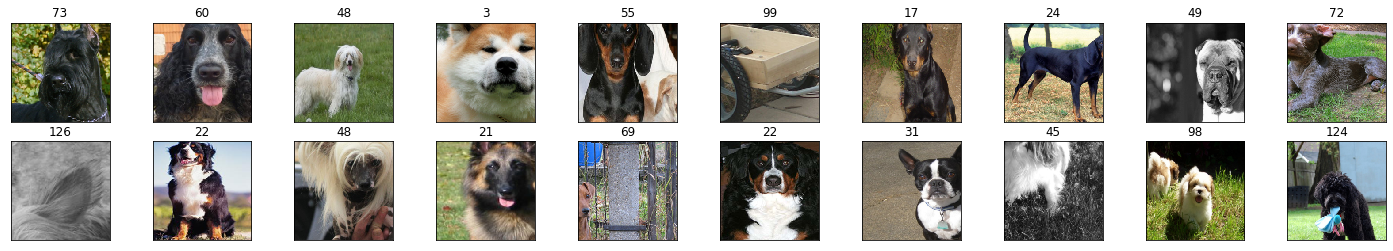

In [39]:
# Visualize some sample data
CLASSES = 133

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(labels[idx].numpy())

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
With regards to preprocessing the images, I resized the pictures to 224x224 which seems to be somewhat of a standard for color images(?). I know with grayscale images 32x32 seems to be ok given MNIST and Fashion-MNIST for a variety of reasons like keeping the number of parameters smaller, faster training/validation and tuning of hyperparameters. I started out with a number of random transforms, but in the end it added too much variation for the model to handle I believe. In general, I think it's better to keep it simple at the start and progress the overall tuning of model/parameters as we progress.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [40]:
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # convolutional layer 
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        # convolutional layer
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # convolutional layer
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # linear layer (7 * 7 * 128 -> 1024)
        self.fc1 = nn.Linear(7 * 7 * 128, 1024)

        # linear layer (1024 -> 133)
        self.fc2 = nn.Linear(1024, CLASSES)
        
        # dropout layer (p=0.05)
        self.dropout = nn.Dropout2d(0.05)
        
        # elu activation
        self.elu = nn.ELU()

        
    def forward(self, x):
        ## Define forward behavior
        # (sees 224x224x3 image tensor as input)
        x = self.elu(self.bn1(self.conv1(x)))

        # (sees 112x112x32 tensor as input)
        x = self.pool(x)

        # (sees 56x56x32 tensor as input)
        x = self.elu(self.bn2(self.conv2(x)))

        # (sees 28x28x64 tensor as input)
        x = self.pool(x)

        # (sees 14x14x64 tensor as input)
        x = self.elu(self.bn3(self.conv3(x)))

        # (sees 14x14x128 tensor as input)
        x = self.pool(x)
        
        # Flatten x with start_dim=1 (sees 7x7x128 tensor as input)
        x = torch.flatten(x, 1)
        
        # add dropout layer
        x = self.dropout(x)

        # add 1st hidden layer, with elu activation function
        x = self.elu(self.fc1(x))
        
        # add dropout layer
        x = self.dropout(x)
        
        # add 1st hidden layer, with elu activation function
        x = self.fc2(x)
        
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=133, bias=True)
  (dropout): Dropout2d(p=0.05, inplace=False)
  (elu): ELU(alpha=1.0)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 
Overall, I was very humbled and completely understand why this is as much of an art as it is a science. I thought the 10% threshhold was quite low until I started seeing my results. I tried larger networks with up to 8 convolutional layers, but because of the number of parameters along with batch size, it was too much for my nVidia 1070. I had to scale it down which probably sacrificed accuracy. It makes perfect sense why using more complex pretrained models can yield better results.

With regards to my final model, I chose to use max pooling, batch normalization and dropout along with the convolutional and fully connected layers. 

I used max pooling because it helps extract features like edges and helps prevent overfitting as well as reducing the spatial size and number of parameters. Average pooling for object detection isn't as good to extract features in this type of application.

I used batch normalization because it helps the model to learn more effectively and and therefore training faster. Another benefit is weight initialization is generally easier for deeper networks, but given this model is smaller - the benefit appears to be marginal from my testing. I acheived about 15% with or without this technique. I also found it was difficult to get anything higher than about 15% which suprised me. I'm curious as to why I couldn't even get a few percent (even up to 20% say). Nevertheless, I wanted to practice different methods here in this project.

I used dropout as another technique to prevent overfitting. It was a small amount as to not to overpenalize input layers or even a dependence of certain input layers. This then helps to improve generalization better.

With regards to hyperparameters - I chose to use batch size of 32, learning rate = 0.001, kept the epochs for this section at 100, varying stride to reduce parameteres and used AdamW for the optimizer. though throughout this project I tested various learning rates and optimizers, Adam/AdamW seems to do the best job learning. Using SGD with a learning rate scheduler (tried in transfer learning) seemed to achieve similar results, but took more epochs to get there.

Finally, the model I went with is:

#### (sees 224x224x3 image tensor as input)
* convolutional layer(input_channels=3 'RGB', output_channels=32, kernel_size=3, stride=2, padding=1)
* batch normalization(output_channels=32)
* elu activation function

#### (sees 112x112x32 tensor as input)
* maxpool

#### (sees 56x56x32 tensor as input)
* convolutional layer(input_channels=32, output_channels=64, kernel_size=3, stride=2, padding=1)
* batch normalization(output_channels=64)
* elu activation function

#### (sees 28x28x64 tensor as input)
* maxpool(stride=2, kernel_size=2)

#### (sees 14x14x64 tensor as input)
* convolutional layer(input_channels=64, output_channels=128, kernel_size=3, stride=1, padding=1)
* batch normalization(output_channels=128)
* elu activation function

#### (sees 14x14x128 tensor as input)
* maxpool(stride=2, kernel_size=2)
        
#### Flatten x with start_dim=1 (sees 7x7x128 tensor as input)
* flatten
        
#### add dropout layer (p=0.05)
* dropout(p=0.05)

#### add 1st hidden layer, with elu activation function
* fully connected layer (7x7x128 -> 1024)
* elu activation function
        
#### add dropout layer (p=0.05)
self.dropout(p=0.05)
        
#### add 1st hidden layer, with elu activation function
* fully connected layer (1024 -> 133)

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [41]:
### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.AdamW(model_scratch.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [42]:
# the following import is required for training to be robust to truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        class_correct = list(0. for i in range(CLASSES))
        class_total = list(0. for i in range(CLASSES)) 
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            ## find the loss and update the model parameters accordingly
            # clear the gradients of all optimized variables
            optimizer_scratch.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model_scratch(data)
            # calculate the loss
            loss = criterion_scratch(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer_scratch.step()
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            #train_loss += loss.item()*data.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model_scratch(data)
            # calculate the loss
            loss = criterion_scratch(output, target)
            # update running validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            _, pred = torch.max(output, 1)
            # compare predictions to true label
            correct = np.squeeze(pred.eq(target.data.view_as(pred)))
            # calculate test accuracy for each object class
            for i in range(len(target)):
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1        

        valid_accuracy = 100. * np.sum(class_correct) / np.sum(class_total)
                
        # print training/validation statistics 
        del data, target, output
        torch.cuda.empty_cache()

        print('Epoch: {} \tLoss: Train/Validation {:.6f}/{:.6f}\tValidation Acc: {:.2f}'.format(
            epoch, 
            train_loss,
            valid_loss,
            valid_accuracy
        ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model_scratch.state_dict(), 'model_scratch.pt')
            valid_loss_min = valid_loss

    # return trained model
    return model


# train the model
model_scratch = train(100, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Loss: Train/Validation 5.317749/5.074172	Validation Acc: 2.16
Validation loss decreased (inf --> 5.074172).  Saving model ...
Epoch: 2 	Loss: Train/Validation 5.063895/5.081497	Validation Acc: 2.87
Epoch: 3 	Loss: Train/Validation 4.983164/5.036591	Validation Acc: 2.75
Validation loss decreased (5.074172 --> 5.036591).  Saving model ...
Epoch: 4 	Loss: Train/Validation 4.906010/4.799355	Validation Acc: 3.71
Validation loss decreased (5.036591 --> 4.799355).  Saving model ...
Epoch: 5 	Loss: Train/Validation 4.861384/4.891536	Validation Acc: 3.83
Epoch: 6 	Loss: Train/Validation 4.838320/4.929159	Validation Acc: 2.99
Epoch: 7 	Loss: Train/Validation 4.760484/4.746292	Validation Acc: 5.87
Validation loss decreased (4.799355 --> 4.746292).  Saving model ...
Epoch: 8 	Loss: Train/Validation 4.730258/4.931678	Validation Acc: 4.79
Epoch: 9 	Loss: Train/Validation 4.678600/4.763384	Validation Acc: 3.95
Epoch: 10 	Loss: Train/Validation 4.654929/5.005013	Validation Acc: 3.95
Epoch: 1

Epoch: 100 	Loss: Train/Validation 2.162838/5.359439	Validation Acc: 15.45


<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [43]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 4.312285


Test Accuracy: 15% (130/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [44]:
## TODO: Specify data loaders
# define training and test data directories
data_dir = 'dogImages/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

In [45]:
# Inception Takes 299x299 images as input, so we resize all of them
train_data_transform = T.Compose([T.RandomResizedCrop(299), 
                                  T.RandomHorizontalFlip(p=0.2),
                                  T.RandomAffine(30, translate=None, scale=None, shear=None, resample=False, fillcolor=0),
                                  T.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
                                  T.RandomGrayscale(p=0.1),
                                  T.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3, fill=0),
                                  T.RandomRotation(5, resample=False, expand=False, center=None, fill=None),
                                  T.ToTensor()])

data_transform = T.Compose([T.RandomResizedCrop(299), 
                            T.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=train_data_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num validation images: ', len(valid_data))
print('Num test images: ', len(test_data))

Num training images:  6680
Num validation images:  835
Num test images:  836


In [46]:
# define dataloader parameters
batch_size = 32
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

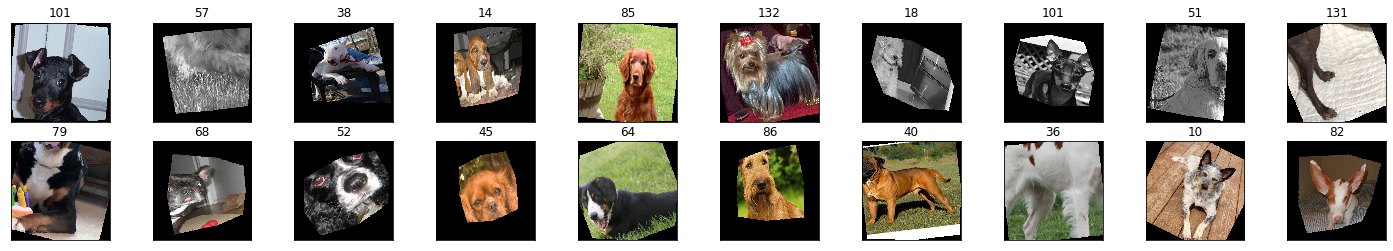

In [47]:
# Visualize some sample data
CLASSES = 133

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display


# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(labels[idx].numpy())

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [48]:
## TODO: Specify model architecture 
model_transfer = models.inception_v3(pretrained=True)
model_transfer.aux_logits=False

# print out the model structure
print(model_transfer)
print(model_transfer.fc.in_features) 
print(model_transfer.fc.out_features)

# Freeze training for all "features" layers
for param in model_transfer.parameters():
    param.requires_grad = False
    
n_inputs = model_transfer.fc.in_features

# add last linear layer (n_inputs -> 133 dog classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, CLASSES)

model_transfer.fc = last_layer

# if GPU is available, move the model to GPU
if use_cuda:
    model_transfer = model_transfer.cuda()

# check to see that your last layer produces the expected number of outputs
print(model_transfer.fc.out_features)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
Based on my previous experimentation, I chose to use Inception V3 model. It has a more complex network architecture of which should be able to better detect subtleties in the different breeds. In the earlier section where I used pretrained models (VGG16, Resnet50 and Inception V3, Inception V3 did marginally better and is the reason I chose to continue using this model. 

I did use many different transforms which probably increased the difficulty in learning, but since I'm using a pretrained model, I wanted to push the model to its limits to learn. You can see above the pictures after the random transforms like color jitter, flipping, grayscaling, etc..

Through experimentation, I chose to keep using AdamW with a learning rate of 0.001. Adam and Adamax performed nearly identical with Adamax seemed to continue learning after 10 epochs where Adam and AdamW seemed to quickly converge to the local minima after only 2-3 epochs. Adamax might perform better given more time. I typically stick with batch size of 32. I decided not to add any additional layers to the model because I wanted to see how it performs by itself. Given more time, I would explore this aspect. 

Overall I achieved 70-75% accuracy so in general it's not too bad. Given more training with the current model, it will not improve accuracy so other modifications will be necessary.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [49]:
# try a bunch of different lr values and how it influences accuracy
#learning_rates = [0.01, 0.03, 0.001, 0.003, 0.0001]
#optimizer_names = ['Adadelta', 'ASGD', 'Adagrad', 'Adamax', 'Adam', 'AdamW']
#optimizers = list([])
#print(len(optimizers))

def generate_optimizersfor_model():
    for learning_rate in learning_rates:
        # try a bunch of different optimizers and how it influences accuracy
        optimizers.append(optim.Adadelta(model_transfer.parameters(), lr=learning_rate))
        optimizers.append(optim.ASGD(model_transfer.parameters(), lr=learning_rate))
        optimizers.append(optim.Adagrad(model_transfer.parameters(), lr=learning_rate))
        optimizers.append(optim.Adamax(model_transfer.parameters(), lr=learning_rate))
        optimizers.append(optim.Adam(model_transfer.parameters(), lr=learning_rate))
        optimizers.append(optim.AdamW(model_transfer.parameters(), lr=learning_rate))


criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.AdamW(model_transfer.parameters(), lr=0.001) #, amsgrad=True

#optimizer_transfer = torch.optim.SGD(model_transfer.parameters(), lr=0.001, momentum=0.9)
#scheduler_transfer = scheduler.ReduceLROnPlateau(optimizer_transfer, 'min')

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [50]:
# train the model
#model_transfer = # train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# number of epochs to train the model
n_epochs = 10

# move to pandas later
pt_state_dicts = list([])
train_losses, valid_losses, test_losses = list([]), list([]), list([])
valid_accuracies = list([])

def train(n_epochs, train_loader, valid_loader, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, model_transfer_name):
    # initialize tracker for minimum validation loss
    # set initial "min" to infinity
    valid_loss_min = np.Inf
   

    for epoch in range(n_epochs):
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0
        train_start, train_end = 0.0, 0.0
        valid_start, valid_end = 0.0, 0.0
        class_correct = list(0. for i in range(CLASSES))
        class_total = list(0. for i in range(CLASSES)) 

        ###################
        # train the model #
        ###################
        model_transfer.train() # prep model for training
        for data, target in train_loader:
            # move tensors to GPU if CUDA is available
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            train_start = time.time()
    
            # clear the gradients of all optimized variables
            optimizer_transfer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model_transfer(data)
            # calculate the loss
            loss = criterion_transfer(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer_transfer.step()
            # update running training loss
            train_loss += loss.item()*data.size(0)
            train_losses.append(train_loss/len(train_loader))
            
        train_end = time.time()
        
        ######################    
        # validate the model #
        ######################
        model_transfer.eval() # prep model for evaluation
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            valid_start = time.time()
                
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model_transfer(data)
            # calculate the loss
            loss = criterion_transfer(output, target)
            # update running validation loss 
            valid_loss += loss.item()*data.size(0)
            valid_losses.append(valid_loss/len(valid_loader))
                    
            _, pred = torch.max(output, 1)
            # compare predictions to true label
            correct = np.squeeze(pred.eq(target.data.view_as(pred)))
            # calculate test accuracy for each object class
            for i in range(len(target)):
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1        
        
        valid_end = time.time()

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_loader.sampler)
        
        # used for SGD testing, but Adam/AdamW learned much faster (~10 vs 50 epochs)
        #scheduler_transfer.step(valid_loss)
        
        valid_accuracy = 100. * np.sum(class_correct) / np.sum(class_total)
        valid_accuracies.append(valid_accuracy)
        
        del data, target, output
        torch.cuda.empty_cache()

        print('Epoch: {} \tLoss: Train/Validation {:.6f}/{:.6f}\tValidation Acc: {:.2f}'.format(
            epoch+1, 
            train_loss,
            valid_loss,
            valid_accuracy
        ))
        
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            #model_at_epoch = 'model_' + str(epoch+1) + '.pt'
            model_at_epoch = model_transfer_name + '_e' + str(epoch+1) + '_tl' + str('{:.6f}').format(train_loss) + '_vl' + str('{:.6f}').format(valid_loss) + '.pt'
            torch.save(model_transfer.state_dict(), model_at_epoch)
            pt_state_dicts.append(model_at_epoch)
            torch.save(model_transfer.state_dict(), 'model_transfer.pt')
            valid_loss_min = valid_loss

    del model_transfer
    # load the model that got the best validation accuracy (uncomment the line below)
    #model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [51]:
#def test(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda):

test_acc = list([])

def test(model_transfer, criterion_transfer, use_cuda):
    # initialize lists to monitor test loss and accuracy
    test_loss = 0.0
    class_correct = list(0. for i in range(CLASSES))
    class_total = list(0. for i in range(CLASSES))

    
    model_transfer.eval() # prep model for evaluation

    for data, target in test_loader:
        # move tensors to GPU if CUDA is available
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_transfer(data)
        # calculate the loss
        loss = criterion_transfer(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(len(target)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

        del data, target, output, pred
        torch.cuda.empty_cache()

    # calculate and print avg test loss
    test_loss = test_loss/len(test_loader.sampler)
    test_losses.append(test_loss/len(test_loader))
    print('Test Loss: {:.6f}\n'.format(test_loss))
    test_accuracy = 100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)
    test_acc.append(test_accuracy)
    
    for i in range(CLASSES):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i+1), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (test_accuracy))

In [52]:
#print(torch.cuda.memory_summary())


def find_best_model():
    for idx, optimizer in enumerate(optimizers):
        # construct model_transfer_name
        lr_idx = idx % len(optimizer_names)
        optimizer_idx = idx // len(optimizer_names)
        model_transfer_name = optimizer_names[optimizer_idx] + '_lr' + str(learning_rates[lr_idx]).replace('0.', '')
        print(model_transfer_name)
        train(n_epochs, train_loader, valid_loader, model_transfer, optimizer, criterion_transfer, use_cuda, model_transfer_name)

        pt_state_dict = pt_state_dicts[-1]
        print(pt_state_dict)
        state_dict = torch.load(pt_state_dict)
        print(state_dict.keys())
        model_transfer.load_state_dict(state_dict)
        test(model_transfer, criterion_transfer, use_cuda)


#print(torch.cuda.memory_summary())

In [53]:
#state_dict = torch.load('SGD_lr001_e50_tl1.829459_vl1.161368.pt')
#print(state_dict.keys())
#model_transfer.load_state_dict(state_dict)

train(n_epochs, train_loader, valid_loader, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'Adam_lr001')

#pt_state_dict = pt_state_dicts[-1]
#print(pt_state_dict)

state_dict = torch.load('model_transfer.pt')
print(state_dict.keys())

model_transfer.load_state_dict(state_dict)
test(model_transfer, criterion_transfer, use_cuda)

Epoch: 1 	Loss: Train/Validation 3.612900/1.851138	Validation Acc: 65.39
Validation loss decreased (inf --> 1.851138).  Saving model ...
Epoch: 2 	Loss: Train/Validation 2.276210/1.311343	Validation Acc: 68.74
Validation loss decreased (1.851138 --> 1.311343).  Saving model ...
Epoch: 3 	Loss: Train/Validation 1.982071/1.113674	Validation Acc: 71.14
Validation loss decreased (1.311343 --> 1.113674).  Saving model ...
Epoch: 4 	Loss: Train/Validation 1.830828/0.994047	Validation Acc: 72.81
Validation loss decreased (1.113674 --> 0.994047).  Saving model ...
Epoch: 5 	Loss: Train/Validation 1.801768/0.924737	Validation Acc: 73.89
Validation loss decreased (0.994047 --> 0.924737).  Saving model ...
Epoch: 6 	Loss: Train/Validation 1.785595/0.933181	Validation Acc: 74.25
Epoch: 7 	Loss: Train/Validation 1.725672/0.917022	Validation Acc: 74.25
Validation loss decreased (0.924737 --> 0.917022).  Saving model ...
Epoch: 8 	Loss: Train/Validation 1.705158/0.842936	Validation Acc: 76.41
Validat

Test Loss: 0.918946

Test Accuracy of     1: 87% ( 7/ 8)
Test Accuracy of     2: 87% ( 7/ 8)
Test Accuracy of     3: 100% ( 6/ 6)
Test Accuracy of     4: 62% ( 5/ 8)
Test Accuracy of     5: 100% (10/10)
Test Accuracy of     6: 87% ( 7/ 8)
Test Accuracy of     7: 28% ( 2/ 7)
Test Accuracy of     8: 62% ( 5/ 8)
Test Accuracy of     9: 50% ( 2/ 4)
Test Accuracy of    10: 33% ( 2/ 6)
Test Accuracy of    11: 77% ( 7/ 9)
Test Accuracy of    12: 66% ( 6/ 9)
Test Accuracy of    13: 50% ( 3/ 6)
Test Accuracy of    14: 88% ( 8/ 9)
Test Accuracy of    15: 90% ( 9/10)
Test Accuracy of    16: 75% ( 6/ 8)
Test Accuracy of    17: 75% ( 6/ 8)
Test Accuracy of    18: 42% ( 3/ 7)
Test Accuracy of    19: 83% ( 5/ 6)
Test Accuracy of    20: 87% ( 7/ 8)
Test Accuracy of    21: 75% ( 6/ 8)
Test Accuracy of    22: 83% ( 5/ 6)
Test Accuracy of    23: 100% ( 8/ 8)
Test Accuracy of    24: 75% ( 6/ 8)
Test Accuracy of    25: 100% ( 4/ 4)
Test Accuracy of    26: 60% ( 3/ 5)
Test Accuracy of    27: 100% ( 8/ 8)
Te

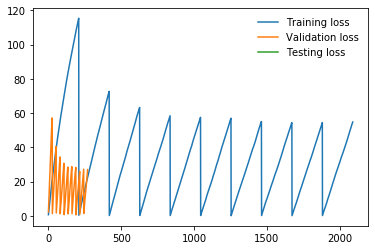

In [54]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.plot(test_losses, label='Testing loss')
plt.legend(frameon=False)

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [161]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_loader.dataset.classes]
#print(train_loader.dataset.classes)

def predict_breed_transfer(img_path):
    img = Image.open(img_path).convert('RGB')

    normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])    

    # compose transform to preprocess image
    transform = T.Compose([T.Resize(299), T.ToTensor(), normalize])
    input_tensor = transform(img)

    # create a mini-batch
    batch = input_tensor.unsqueeze(0)

    # push tensor through model for prediction
    model = model_transfer.cpu()
    model.eval()
    output = model(batch)

    idx = torch.argmax(output)
    
    #_, pred = torch.max(output, 1)
    print(idx)

    # highest predicted class index
    return idx

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [162]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    result = dog_detector_inception_v3(img_path)
    if dog_detector_inception_v3(img_path) == True:
        prediction = predict_breed_transfer(img_path)
        print("hello furry friend, you are a {}".format(class_names[prediction]))
    elif face_detector_keypoint(img_path, True) > 0:
        prediction = predict_breed_transfer(img_path)
        print("hello human, if you were a furry friend, you look like a {}".format(class_names[prediction]))
    else:
        print("hello, you don't look like a furry friend or a human...")

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
Overall, it performed well. Three areas I would improve upon are:
* weight initialization, 
* do more with learning rate scheduling and 
* experimenting more with diffferent pretrained models as I suspect in this case Inception V3 may not be the best performing (or at least add a few layers to see if it helps fine-tune the model to get better accuracy.

In [163]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
human_files = ['human1.jpg', 'human2.jpg', 'cat1.jpg']
dog_files = ['Glen_of_imaal_terrier.jpg', 'german_Shepherd.jpg', 'black_lab.jpg']

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)

hello human, if you were a furry friend, you look like a Labrador retriever
hello human, if you were a furry friend, you look like a Labrador retriever
hello, you don't look like a furry friend or a human...
hello furry friend, you are a Labrador retriever
hello furry friend, you are a Labrador retriever
hello furry friend, you are a Labrador retriever


In [ ]:
run_app('Glen_of_imaal_terrier.jpg')

### Appendix A: List of links I searched (but not completely read necessarily):

* PyTorch docs
https://pytorch.org/docs/stable/
* Creating your own Haar Cascade OpenCV Python Tutorial
https://pythonprogramming.net/haar-cascade-object-detection-python-opencv-tutorial/
* Introduction and Use - Tensorflow Object Detection API Tutorial
https://pythonprogramming.net/introduction-use-tensorflow-object-detection-api-tutorial/
* YOLO object detection with OpenCV
https://www.pyimagesearch.com/2018/11/12/yolo-object-detection-with-opencv/
* YOLOv3: An Incremental Improvement
https://arxiv.org/pdf/1804.02767.pdf
* Selective Search for Object Detection (C++ / Python)
https://www.learnopencv.com/selective-search-for-object-detection-cpp-python/
* YOLO Object Detection Introduction
https://gilberttanner.com/blog/yolo-object-detection-introduction
* Detectron2 - Object Detection with PyTorch
https://gilberttanner.com/blog/detectron-2-object-detection-with-pytorch
* Deep learning : Simplest way to implement YOLO — an extremely powerful object detection system— using Python
https://becominghuman.ai/deep-learning-simplest-way-to-implement-yolo-an-extremely-powerful-object-detection-algorithm-9eae9d6191b7
* YOLO Object Detection with OpenCV and Python
https://www.arunponnusamy.com/yolo-object-detection-opencv-python.html
https://github.com/arunponnusamy/object-detection-opencv
* YOLO DNNs
https://docs.opencv.org/3.4.2/da/d9d/tutorial_dnn_yolo.html
* A very shallow overview of YOLO and Darknet
https://martinapugliese.github.io/recognise-objects-yolo/
* Understanding YOLO
https://hackernoon.com/understanding-yolo-f5a74bbc7967
* Real-time Object Detection with YOLO, YOLOv2 and now YOLOv3
https://medium.com/@jonathan_hui/real-time-object-detection-with-yolo-yolov2-28b1b93e2088
* A Practical Guide to Object Detection using the Popular YOLO Framework – Part III (with Python codes)
https://www.analyticsvidhya.com/blog/2018/12/practical-guide-object-detection-yolo-framewor-python/
* Reproducing training performance of YOLOv3 in PyTorch (Part 0)
https://medium.com/@hirotoschwert/reproducing-training-performance-of-yolov3-in-pytorch-part-0-a792e15ac90d
* Real time object detection [PyTorch]||[YOLO]
https://towardsdatascience.com/real-time-object-detection-pytorch-yolo-f7fec35afb64
* Training Yolo for Object Detection in PyTorch with Your Custom Dataset — The Simple Way
https://towardsdatascience.com/training-yolo-for-object-detection-in-pytorch-with-your-custom-dataset-the-simple-way-1aa6f56cf7d9
* How to implement a YOLO (v3) object detector from scratch in PyTorch: Part 2
https://blog.paperspace.com/how-to-implement-a-yolo-v3-object-detector-from-scratch-in-pytorch-part-2/
* R-CNN, Fast R-CNN, Faster R-CNN, YOLO — Object Detection Algorithms
https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e
* PyTorch Tutorial: How to Develop Deep Learning Models with Python
https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/
* Transfer Learning with Convolutional Neural Networks in PyTorch
https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce
* PyTorch 101, Part 4: Memory Management and Using Multiple GPUs
https://blog.paperspace.com/pytorch-memory-multi-gpu-debugging/
* A Beginner's Guide To Understanding Convolutional Neural Networks Part 2
https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/
* cs231n - cnn's
https://cs231n.github.io/convolutional-networks/#layers
* Master the COCO Dataset for Semantic Image Segmentation — Part 1 of 2
https://towardsdatascience.com/master-the-coco-dataset-for-semantic-image-segmentation-part-1-of-2-732712631047
* Master the COCO Dataset for Semantic Image Segmentation — Part 2 of 2
https://towardsdatascience.com/master-the-coco-dataset-for-semantic-image-segmentation-part-2-of-2-c0d1f593096a
* A guide to Face Detection in Python
https://towardsdatascience.com/a-guide-to-face-detection-in-python-3eab0f6b9fc1
* Selecting and preparing a specific subset of images from the COCO dataset to train YOLO Object Detection Model
https://medium.com/swlh/selecting-and-preparing-a-specific-subset-of-images-from-the-coco-dataset-to-train-yolo-object-1ba8cd0e9f8
* Popular Datasets Over Time
https://www.kaggle.com/benhamner/popular-datasets-over-time
* Mask R-CNN Instance Segmentation with PyTorch
https://www.learnopencv.com/mask-r-cnn-instance-segmentation-with-pytorch/
* Viola Jones face detection and tracking explained
https://www.youtube.com/watch?v=WfdYYNamHZ8
* Face detection with OpenCV and deep learning
https://www.pyimagesearch.com/2018/02/26/face-detection-with-opencv-and-deep-learning/
* Image Segmentation with Watershed Algorithm
https://docs.opencv.org/3.4/d3/db4/tutorial_py_watershed.html
* Object Detection for Dummies Part 3: R-CNN Family
https://lilianweng.github.io/lil-log/2017/12/31/object-recognition-for-dummies-part-3.html
* http://yann.lecun.com/exdb/mnist/
